In [118]:
import torch
import sklearn.datasets as skds
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision
from torch import nn
import numpy
import pandas
from typing import Optional
from tqdm import tqdm

# Creating custom dataset from CSV file

In [119]:
class MyDiabetesDataset(torch.utils.data.Dataset):
	def __init__(self, csv_file, batch_size: Optional[int] = None):
		self.data = pandas.read_csv(csv_file, sep="\t")
		# if batch_size:
		# 	assert batch_size > 0
		# 	self.batch_size = batch_size

	def __len__(self):
		return len(self.data)

	def __getitem__(self, index):
		#print("Returning sample at index {}".format(index))
		data = self.data.iloc[index]
		data = data.to_numpy().astype(numpy.float32)
		target = data[10]  # column Y is the target
		data = data[0:10]  # other columns are the features to train on
		data = torch.tensor(data)

		#target = data[10]
		target = torch.tensor(target, dtype=torch.float32)
		#target = target.type(torch.LongTensor)

		return data , target

num_batches = 5
dataset = MyDiabetesDataset("diabetes.csv", batch_size=num_batches)
print(dataset[0], type(dataset[0]))
print(f"There are {num_batches} batches of data, each batch is of size {len(dataset)/num_batches}")
dataset.data

(tensor([ 59.0000,   2.0000,  32.1000, 101.0000, 157.0000,  93.2000,  38.0000,
          4.0000,   4.8598,  87.0000]), tensor(151.)) <class 'tuple'>
There are 5 batches of data, each batch is of size 88.4


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


# Creating custom loader for our custom dataset

This allows:
- Batching
- Shuffling the data
- Load the data in parallel using `multiprocess` workers

In [120]:
dataloader = DataLoader(dataset, batch_size=num_batches)

In [121]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched)

0 [tensor([[ 59.0000,   2.0000,  32.1000, 101.0000, 157.0000,  93.2000,  38.0000,
           4.0000,   4.8598,  87.0000],
        [ 48.0000,   1.0000,  21.6000,  87.0000, 183.0000, 103.2000,  70.0000,
           3.0000,   3.8918,  69.0000],
        [ 72.0000,   2.0000,  30.5000,  93.0000, 156.0000,  93.6000,  41.0000,
           4.0000,   4.6728,  85.0000],
        [ 24.0000,   1.0000,  25.3000,  84.0000, 198.0000, 131.4000,  40.0000,
           5.0000,   4.8903,  89.0000],
        [ 50.0000,   1.0000,  23.0000, 101.0000, 192.0000, 125.4000,  52.0000,
           4.0000,   4.2905,  80.0000]]), tensor([151.,  75., 141., 206., 135.])]
1 [tensor([[ 23.0000,   1.0000,  22.6000,  89.0000, 139.0000,  64.8000,  61.0000,
           2.0000,   4.1897,  68.0000],
        [ 36.0000,   2.0000,  22.0000,  90.0000, 160.0000,  99.6000,  50.0000,
           3.0000,   3.9512,  82.0000],
        [ 66.0000,   2.0000,  26.2000, 114.0000, 255.0000, 185.0000,  56.0000,
           4.5500,   4.2485,  92.0000],


# Creating model

In [122]:
# model = nn.Sequential(
# 	nn.BatchNorm1d(10),  # We use batch normalization because this dataset contains many unique numbers, its hard to train. Normalization sets the values between 0 and 1 so its easier to train.
# 	nn.Linear(10, 32),
# 	nn.BatchNorm1d(32),
# 	nn.ReLU(),
# 	nn.Linear(32, 256),
# 	nn.BatchNorm1d(256),
# 	nn.ReLU(),
# 	nn.Linear(256, 1024),
# 	nn.BatchNorm1d(1024),
# 	nn.ReLU(),
# 	nn.Linear(1024, 1),
# 	nn.Sigmoid()
# )
# model

model = nn.Sequential(
	nn.Linear(10, 500),
	nn.ReLU(),
	nn.Linear(500, 100),
	nn.ReLU(),
	nn.Linear(100, 1),
	nn.ReLU()
)
model

Sequential(
  (0): Linear(in_features=10, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
  (5): ReLU()
)

# Train

Target is last column (column 11 is measure of diabetes, is a number, not classical linear regression!)

### Set cost function, optimizer function

In [123]:
#CE_loss=nn.NLLLoss()
#CE_loss = nn.CrossEntropyLoss()
CE_loss = nn.MSELoss()  # This is a regression problem, not a classification problem! Took me a while to figure this out.
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.9)

### Set batch processing function

In [124]:

def iterate_batch(batch_num, sample, targets):
	
	#batch, targets = next(iter(iter_batch))
	#print(targets)


	optimizer.zero_grad() # Zero gradient before every batch
	y_model = model(sample)

	loss = CE_loss(y_model, targets)  # Calculate loss

	batch_num = batch_num + 1
	#print(f"batch: {batch_num}, loss: {loss}")

	loss.backward()  # Calculate gradients
	optimizer.step()  # Update weights

	# Print statistics
	#predicated_Y = y_model.argmax(dim=1)
	#acc = (targets.sum() - predicated_Y.sum()) / len(targets)
	#acc = (predicted_labels == targets).sum()/len(targets)
	acc = torch.tensor([0.])  # TODO: Calculate accuracy
	
	return loss.detach(), acc.detach()

In [125]:
def iterate_epoch():
	running_loss=0.
	running_acc=0.

	for i_batch, batch in enumerate(dataloader):
		sample, targets = batch
		#print(targets)
		batch_loss, batch_acc = iterate_batch(i_batch, sample, targets)
		running_loss += batch_loss
		running_acc +=  batch_acc
	
	# for batch_idx in range(num_batches):
	# 	batch_loss, batch_acc = iterate_batch()
	# 	running_loss += batch_loss
	# 	running_acc +=  batch_acc
	loss = running_loss/num_batches
	acc = running_acc/num_batches
	return loss, acc

# Train

In [126]:
epochs=20

loss_train=torch.zeros(epochs)
acc_train=torch.zeros(epochs)
loss_test=torch.zeros(epochs)
acc_test=torch.zeros(epochs)

model[0].reset_parameters()
for epoch_idx in tqdm(range(epochs)):
	#print(f"Epoch: {epoch_idx}")
	loss_train[epoch_idx], acc_train[epoch_idx] = iterate_epoch()
  #loss_test[epoch_idx], acc_test[epoch_idx] = eval_model_test()

  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\Shlomi\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Shlomi\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


Text(0.5, 0, 'Epoch Number')

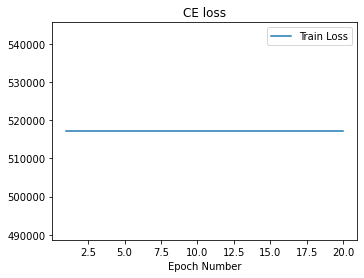

In [127]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1,epochs+1),loss_train,label="Train Loss")
#plt.plot(range(1,epochs+1),loss_test,label="Test Loss")
plt.title("CE loss")
plt.legend()
plt.xlabel("Epoch Number")

# plt.subplot(1,2,2)
# plt.plot(range(1,epochs+1),acc_train,label="Train Acc")
# #plt.plot(range(1,epochs+1),acc_test,label="Test Acc")
# plt.title("Accuracy")
# plt.legend()
# plt.xlabel("Epoch Number")